Schuller et al., eIF5A Functions Globally in Translation Elongation and Termination, Molecular Cell (2017), http:// dx.doi.org/10.1016/j.molcel.2017.03.003

Polarity at position i in gene with length l is defined as:

$w_i = {{2i-(l+1)}\over{l - 1}}$

$p_i = {{d_i w_i}\over{\sum_{i=1}^l d_i}}$

In [4]:
import sys
import xlrd
import pandas as pd
import numpy as np
from numpy import median
import os
import fnmatch 

INPUTS = "/Users/jiz225/Desktop/ZidLab/polarity/input"
OUTPUTS = "/Users/jiz225/Desktop/ZidLab/polarity/outputcsv"

'''
Description: Parse the input file to start at 15 bps upstream of each gene
    Input: path for input file and path for new csv file generated
'''
def makecsv(inputpath, outputpath):
    inputf = open(inputpath,'r')
    outputf = open(outputpath, 'w')
    outputf.write('Name'+ ',' + 'Orient' + ',' + 'Start' + ',' + 'End' + ',' + 'Position' + ',' +'Length' + ',' + 'RelativePosition' + ',' + 'Counts' + '\n')
    rposit = -1000
    while True:
        line = inputf.readline()
        if not line:
            break
    
        string = line.rstrip() 
        cells = string.split('\t')
        name = cells[0][:7] 
        orient = cells[0][6:7]
        start = cells[1]
        end = cells[2]
        length = abs(int(start) - int(end))
        riboCount = cells[4]
        posit = cells[3]
        
        if orient == 'W':
            rposit = (int(cells[3])+1 - (int(start)))
    
        elif orient == "C":
            rposit = ((int(start))-(int(cells[3])-1))
            
        if rposit > 0 and rposit <(length-15):
            outputf.write(str(name) + ',' + str(orient) + ',' + str(start) + ',' + str(end) + ',' + str(posit) + ',' + str(length-15) + ',' + str(rposit) + ',' + str(riboCount) + '\n')
    inputf.close()
    outputf.close()
    
inputlist = []
outputlist = []
inputfolder = os.listdir(INPUTS)
extension = "*.xls"
for doc in inputfolder:
    if fnmatch.fnmatch(doc, extension):
        #change this input and ouput file path
        inputpath = str("/Users/jiz225/Desktop/ZidLab/polarity/input/") + doc
        namelist = doc.split('.')
        name = namelist[0]
        outputpath = str("/Users/jiz225/Desktop/ZidLab/polarity/output/") + name + str(".csv")
        inputlist.append(inputpath)
        outputlist.append(outputpath)
Gene_Polarity_all = []

In [5]:
%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
from itertools import accumulate
import numpy as np
import scipy.stats as stats
import pylab as pl

def calculatePolarity(i, l, densityati, density):
    normDist = (2*i - (l + 1))/(l - 1)
    polarity = densityati*normDist/density
    return polarity

def PolarityPerGene(inputpath, destdir):
    df1 = pd.read_csv(inputpath)
    names = inputpath.split('.')
    names1 = names[0].split('/')
    #this is the final output file
    nameofcsv = destdir + names1[len(names1) - 1] + str("_polarity&gene.csv")
    print(nameofcsv)
    Namelist = df1['Name'].tolist()
    Countslist = df1['Counts'].tolist()
    Orientlist = df1['Orient'].tolist()
    Positionlist = df1['Position'].tolist()

    startp = 0
    for i in range (len(Namelist) - 1):
        if Namelist[i + 1] == Namelist[i]:
            Countslist[i + 1] += Countslist[i]
        else:
            for j in range (startp, i+1):
                Countslist[j] = Countslist[i]
            startp = i + 1
 
    df = pd.DataFrame({'col':Countslist})
    df1['TotalCounts'] = Countslist
    Totalcountlist = df1['TotalCounts'].tolist()
    Countsperilist = df1['Counts'].tolist()
    Lengthlist = df1['Length'].tolist()
    Positlist = df1['RelativePosition'].tolist()
    Polaritylist = []
    Genelist = []
    for i in range (len(Namelist)):
        polarityofi = calculatePolarity(Positlist[i], Lengthlist[i], Countsperilist[i], Totalcountlist[i])
        Polaritylist.append(polarityofi)
        newname = str(Namelist[i]) + str(Orientlist[i])
        Genelist.append(newname)
    df = pd.DataFrame({'col':Polaritylist})
    df1['Polarity'] = Polaritylist
    
    print(nameofcsv)
    #calculate total polarity and ribosome occupancy
    Gene_Polarity = {}
    ribo = []
    geneP = df1['Polarity'].tolist()
    '''
    totalribo = 0
    for i in range (len(Namelist)):
        totalribo += Totalcountlist[i]
    for i in range (len(Namelist)): 
        ribo.insert(i, Totalcountlist[i] / totalribo)
    '''   
    for i in range (len(Namelist) - 1):
        if Namelist[i + 1] == Namelist[i]:
            geneP[i + 1] += geneP[i]
            geneP[i] = -1000
        else:
            Gene_Polarity[Namelist[i]] = geneP[i]
    for i in range (len(Namelist)):
        if Totalcountlist[i] < 100:
            Totalcountlist[i] = -1000
        elif geneP[i] >= 1.0 or geneP[i] <= -1.0:
            geneP[i] = -1000
    df = pd.DataFrame({'col':geneP})
    df1['PolarityPerGene'] = geneP
    d = {'Name':Genelist,'PolarityPerGene': geneP}
    dfcsv = pd.DataFrame(data=d)
    dfcsv = dfcsv.replace(-1000, np.nan)
    dfcsv = dfcsv.dropna(how='any',axis=0)
    pllist = dfcsv['PolarityPerGene'].tolist()
    print(len(dfcsv['Name'].tolist()))
    '''
    plt.scatter(pslist, pllist, alpha=0.5)
    plt.show()
    '''
    pllist.sort()
    percentage = []
    x = 1/ int(len(pllist))
    for i in range(0, len(pllist)):
        percentage.insert(i, x)
        x += 1/ int(len(pllist))
   
    plt.plot(pllist, percentage)
    plt.ylabel('Cumulative Distribution(%)')
    plt.xlabel('Change in Polarity')
    #plt.show()
    plt.savefig(names[0] + '-Cumulative Distribution.png')
    plt.close()
    fit = stats.norm.pdf(pllist, np.mean(pllist), np.std(pllist))
    pl.plot(pllist,fit)
    pl.hist(pllist,normed=True)  
    #pl.show()
    pl.savefig(names[0] + '-Normalized Distribution.png')
    pl.close()
    #print('The Median is:' + str(pslist[np.argsort(pllist)[len(pllist)//2]]) + ',' + str(median(pllist)))
    #df1.to_csv(nameofcsv)
    dfcsv.to_csv(nameofcsv)
    dictionary = dict(zip(dfcsv['Name'].tolist(), dfcsv['PolarityPerGene'].tolist()))
    return dictionary
    

Populating the interactive namespace from numpy and matplotlib


In [6]:
destdir = "/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/"
for i in range(0, len(inputlist)):
    makecsv(inputlist[i], outputlist[i])
    polpergene = PolarityPerGene(outputlist[i], destdir)
    #pols.append(polpergene)
print('\n Number of possible input files: ' + str(len(inputlist)))
print('\n Number of possible output csv files: ' + str(len(outputlist)))

/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/BY-Ribo__-Glu15B-sorted_polarity&gene.csv
/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/BY-Ribo__-Glu15B-sorted_polarity&gene.csv
5337


/Users/jiz225/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/BY-Ribo_logphaseB-sorted_polarity&gene.csv
/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/BY-Ribo_logphaseB-sorted_polarity&gene.csv
5345

 Number of possible input files: 2

 Number of possible output csv files: 2


In [8]:
import sys
import xlrd
import pandas as pd
import numpy as np
from numpy import median
import os
import fnmatch 
import csv

x = []
y = []

def findIntersection1 (filepath1, filepath2):
    global x, y
    x = []
    y = []
    df1 = pd.read_csv(filepath1)
    df2 = pd.read_csv(filepath2)
    dictionary1 = dict(zip(df1['Name'].tolist(), df1['PolarityPerGene'].tolist()))
    dictionary2 = dict(zip(df2['Name'].tolist(), df2['PolarityPerGene'].tolist()))
    set1 = set(dictionary1)
    set2 = set(dictionary2)
    #print(pols[1])

    for name in set1.intersection(set2):
        #print(name + ' ' + str(pols[1][name]) + ' ' + str(pols[2][name]))
        x.append(dictionary1[name])
        y.append(dictionary2[name])
        
def findIntersection2 (dictionary1, dictionary2):
    global x, y
    x = []
    y = []
    set1 = set(dictionary1)
    set2 = set(dictionary2)
    
    for name in set1.intersection(set2):
        x.append(dictionary1[name])
        y.append(dictionary2[name])
        
def findIntersection3 (filepath1, dictionary2):
    global x, y
    x = []
    y = []
    df1 = pd.read_csv(filepath1)
    dictionary1 = dict(zip(df1['Name'].tolist(), df1['PolarityPerGene'].tolist()))
    set1 = set(dictionary1)
    set2 = set(dictionary2)

    for name in set1.intersection(set2):
        x.append(dictionary1[name])
        y.append(dictionary2[name])        
        
def findDiff (filepath1, filepath2):
    diff = {}
    df1 = pd.read_csv(filepath1) #+Glu
    df2 = pd.read_csv(filepath2) #-Glu
    dictionary1 = dict(zip(df1['Name'].tolist(), df1['PolarityPerGene'].tolist()))
    dictionary2 = dict(zip(df2['Name'].tolist(), df2['PolarityPerGene'].tolist()))
    set1 = set(dictionary1)
    set2 = set(dictionary2)
    #print(pols[1])

    for name in set1.intersection(set2):
        #print(name + ' ' + str(pols[1][name]) + ' ' + str(pols[2][name]))
        diff[name] = float(dictionary2[name]) - float(dictionary1[name])        
 
    return diff    
    
def WriteDictToCSV(outputpath, diff):
    outputcsv = open(outputpath, 'w')
    for key, val in diff.items():
        outputcsv.write(str(key) + ',' + str(val) + '\n')
    outputcsv.close()
    print(outputpath)
filepath1 = '/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/BY-Ribos/BY-Ribo_logphaseB-sorted_polarity&gene.csv'
filepath2 = '/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/BY-Ribos/BY-Ribo__-Glu15B-sorted_polarity&gene.csv'
diff = findDiff (filepath1, filepath2)
outputpath = '/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/BY-Ribos' + '/BY_Ribo_B_Delta.csv'
print(diff)
WriteDictToCSV(outputpath, diff)

{'YDR106WW': -0.29610182975338106, 'YLR028CC': 0.20048678397832045, 'YGL222CC': 0.18531774642084664, 'YPL176CC': 0.27311800355557897, 'YKL184WW': 0.2708592116076086, 'YIL160CC': 0.15382838664972862, 'YLR021WW': -0.08296388124303981, 'YAL047CC': -0.0964922806175506, 'YER094CC': 0.3291225279470678, 'YLR395CC': 0.09918251950556661, 'YKR039WW': 0.15028331043956034, 'YDR129CC': 0.062370091673137174, 'YNL288WW': 0.10975228306488208, 'YBR252WW': 0.18485261506314407, 'YGR287CC': 0.04484828728981608, 'YBR163WW': -0.20543110600548845, 'YOR056CC': 0.2333933872488541, 'YKL063CC': 0.029545973077800602, 'YPL012WW': 0.28921936355430194, 'YLR016CC': 0.02107510134265997, 'YPR095CC': 0.09001820662172558, 'YML031WW': 0.3164088551932725, 'YPR129WW': 0.23255332359094255, 'YOR264WW': 0.06101504477477754, 'YPL180WW': 0.23727774066946453, 'YPL265WW': 0.13456464607742286, 'YLR049CC': 0.2623624195191103, 'YGL163CC': 0.28073694029850743, 'YNL223WW': 0.06785938083067566, 'YOL090WW': 0.17384349589874226, 'YPL013CC

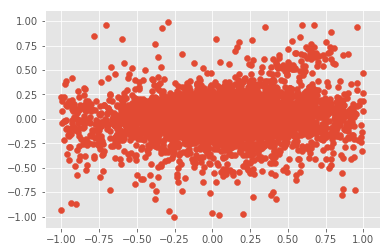

In [63]:
np.corrcoef(x, y)
matplotlib.style.use('ggplot')

plt.scatter(x, y)
plt.show()